## Visualizing CNN filters



#### Additional Setup

This module uses the `pillow` imaging library for displaying the filters. Confirm that the library is installed by executing the cell below. If it is not installed, please install using  `conda install pillow`

In [2]:
try:
    import PIL.Image
except ImportError:
    print("The pillow library is not installed")

In [4]:
# Load libraries

from __future__ import print_function

import numpy as np
import time
import keras.preprocessing.image as image
from keras.applications import vgg16
from keras import backend as K

import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline

Using TensorFlow backend.


## Helper Functions

This content is derived from [here](https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py).

[Results example](http://i.imgur.com/4nj4KjN.jpg)

Keras does not have pre-built functions for visualizing convolutional filters yet. We have to dig a little deeper into the backend (in this case TensorFLow) and leverage the lower-level functionality to achieve this.

In this method, we use reverse steepest descent to refine an input image to maximize the activation of a selected filter from a chosen layer (a "neuron"). 
    1. Start with a gray image with some random noise as initial input
    2. Calculate the _loss_ as the mean value of the pixels in the output of the selected filter
    3. Calculate the gradient of this loss function
    4. Adjust the values of the input image using the calculated gradients and a step-size
    5. Repeat steps 2-4 a fixed number of times
    6. Reconstruct an image from the updated input data
    
    

In [5]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.

This script can run on CPU in a few minutes.

Results example: http://i.imgur.com/4nj4KjN.jpg
'''

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def enhance_filters(layer_dict, layer_name, model, filter_count):
    input_image = model.input
    kept_filters = []
    for filter_index in range(filter_count):
        # we only scan through the first 200 filters,
        # but there are actually 512 of them
        print('Processing filter %d' % filter_index)
        start_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            #print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        end_time = time.time()
        print('Filter %d processed in %ds' % (filter_index, end_time - start_time))
    return kept_filters

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
def visualize(layer_name, filter_count=None):
    #layer_name = 'block1_conv1'


    # we will stich the best 64 filters on a 8 x 8 grid.
    n = 4
    kept_filters = enhance_filters(layer_dict, layer_name, model,\
                                   filter_count if filter_count else (n+1)**2)

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 2
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

    # save the result to disk
    image.array_to_img(stitched_filters).save('%s_stitched_filters_%dx%d.png' % (layer_name, n, n))

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

#### Producing the visualizations

In the cell below, set the value of `layer` to the name of the layer you want to view, e.g., *block1_conv1*. This will produce an image which can be loaded using the immediately following cell. In each layer, the code picks 16 filters with the highest activations from the first 25. This is done to reduce the processing time. You can change this by specifying the number of filters to visualize as an argument (`filer_count`) to the function `visualize`.

The processing time increases with the number of weights -- filters from earlier layers (e.g., block1) take less time to enhance than those from deeper layers (e.., block5)

In [11]:
layer = "block5_conv1"
visualize(layer)


Processing filter 0
Filter 0 processed in 10s
Processing filter 1
Filter 1 processed in 6s
Processing filter 2
Filter 2 processed in 10s
Processing filter 3
Filter 3 processed in 6s
Processing filter 4
Filter 4 processed in 8s
Processing filter 5
Filter 5 processed in 10s
Processing filter 6
Filter 6 processed in 6s
Processing filter 7
Filter 7 processed in 10s
Processing filter 8
Filter 8 processed in 10s
Processing filter 9
Filter 9 processed in 6s
Processing filter 10
Filter 10 processed in 9s
Processing filter 11
Filter 11 processed in 6s
Processing filter 12
Filter 12 processed in 1s
Processing filter 13
Filter 13 processed in 9s
Processing filter 14
Filter 14 processed in 10s
Processing filter 15
Filter 15 processed in 6s
Processing filter 16
Filter 16 processed in 2s
Processing filter 17
Filter 17 processed in 9s
Processing filter 18
Filter 18 processed in 6s
Processing filter 19
Filter 19 processed in 1s
Processing filter 20
Filter 20 processed in 10s
Processing filter 21
Filte

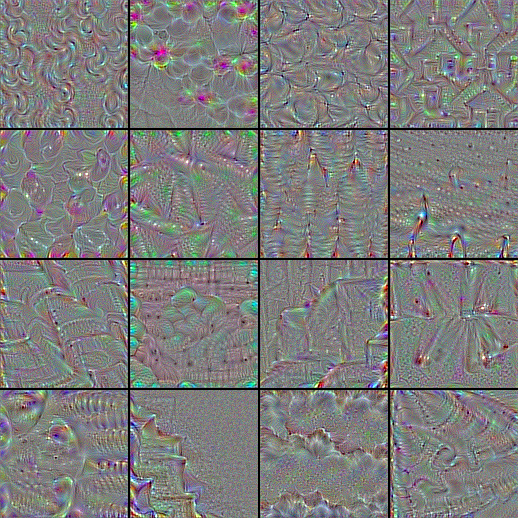

In [13]:
display(Image('%s_stitched_filters_%dx%d.png' % (layer, 4, 4)))